# Operator-weighted pCN: GP Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal
from scipy.interpolate import interp1d
from scipy.optimize import minimize

import tinyDA as tda

In [2]:
np.random.seed(456)

### Defining the true model and generating some data

In [3]:
# define some function
def latent_function(x):
    return np.sin(2*np.pi*x)

In [4]:
# set the number of datapoints and the desired noise
n_data = 10
sigma = 0.1

# draw some random datapoints, evaluate the function and add noise.
x_data = np.random.uniform(size=n_data)
y_data = latent_function(x_data) + np.random.normal(0, sigma, size=x_data.shape[0])

# set the basis.
x = np.linspace(0,1)

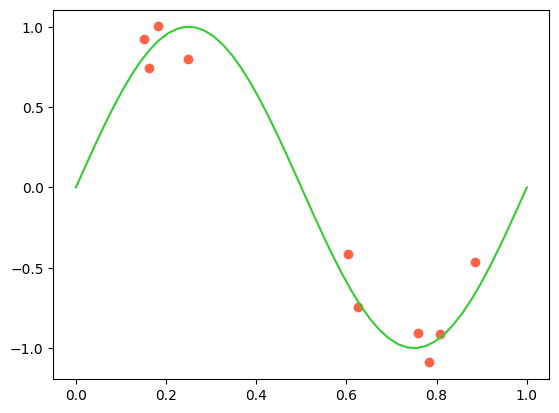

In [5]:
# plot the true function and the datapoints.
plt.plot(x, latent_function(x), c='limegreen')
plt.scatter(x_data, y_data, c='tomato')
plt.show()

### Set up the statistical model

In [6]:
# define the GP kernel (squared exponential)
def kernel(x, y, l):
    return np.exp(-0.5 * (x - y)**2 / l**2)

In [7]:
# set the length scale and the dimension of the basis.
l = 0.1
n_x = x.shape[0]

# construct the kernel matrix
K = np.zeros((n_x, n_x))
for i in range(n_x):
    for j in range(n_x):
        K[i,j] = kernel(x[i], x[j], l)

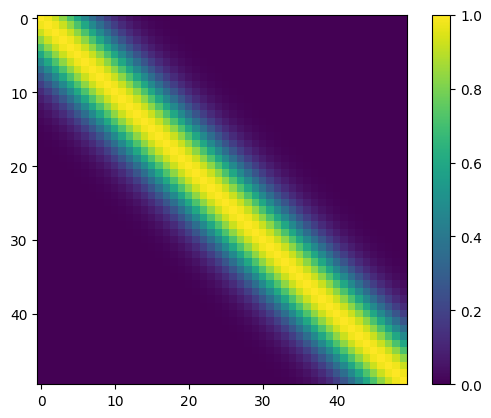

In [8]:
# plot the kernel matrix
plt.imshow(K)
plt.colorbar()
plt.show()

In [9]:
# set the GP prior
mean_prior = np.zeros(n_x)
my_prior = multivariate_normal(mean=mean_prior, cov=K+1e-3*np.eye(n_x))

# set the Gaussian likelihood
cov_likelihood = sigma**2*np.eye(n_data)
my_loglike = tda.GaussianLogLike(y_data, cov_likelihood)

In [10]:
# define a model.
def my_model(y):

    # interpolate the GP function
    f = interp1d(x, y)
    
    # evaluate at datapoints
    return f(x_data)

In [11]:
# initialise the Posterior
my_posterior = tda.Posterior(my_prior, my_loglike, my_model)

In [12]:
# get the MAP point using minimize, which also approximates the Hessian for free.
_MAP = minimize(lambda x: -my_posterior.create_link(x).posterior, x0=my_prior.rvs())
MAP = _MAP['x']
H_inv = _MAP.hess_inv

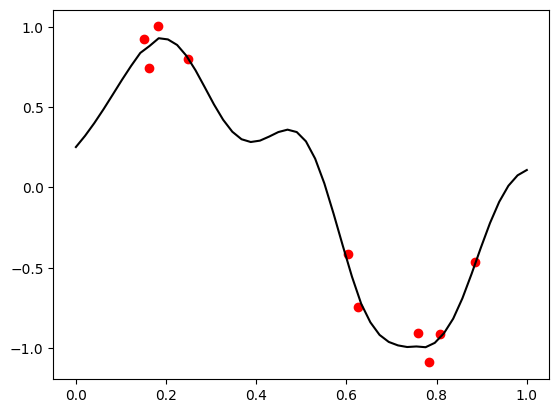

In [13]:
# plot the MAP estimate.
plt.plot(x, MAP, c='k')
plt.scatter(x_data, y_data, c='r')
plt.show()

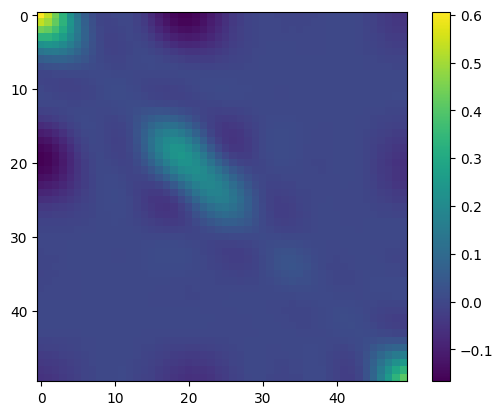

In [14]:
# plot the Hessian approximation.
plt.imshow(H_inv)
plt.colorbar()
plt.show()

### Set up the proposal

In [15]:
# preconditioned Crank-Nicolson
#pcn_adaptive = True
#my_proposal = tda.CrankNicolson(adaptive=pcn_adaptive)

# preconditioned Crank-Nicolson
pcn_operator = H_inv
pcn_adaptive = True
my_proposal = tda.OperatorWeightedCrankNicolson(pcn_operator, adaptive=pcn_adaptive)

### Sample

In [16]:
import os
if "CI" in os.environ:
    iterations = 120
    burnin = 20
else:
    iterations = 12000
    burnin = 2000

In [17]:
my_chains = tda.sample(my_posterior, my_proposal, iterations=iterations, n_chains=2, initial_parameters=MAP, force_sequential=True)

Sampling chain 1/2


Running chain, α = 0.22: 100%|███████████| 12000/12000 [00:48<00:00, 246.49it/s]


Sampling chain 2/2


Running chain, α = 0.15: 100%|███████████| 12000/12000 [00:49<00:00, 241.81it/s]


### Get some diagnostics

In [18]:
import arviz as az

In [19]:
idata = tda.to_inference_data(my_chains, burnin=burnin)

/home/mikkel/.cache/pypoetry/virtualenvs/tinyda-p_DUFDjW-py3.8/lib/python3.8/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


In [20]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta_0,0.327,0.999,-1.555,2.164,0.043,0.030,541.0,1252.0,1.01
theta_1,0.312,0.925,-1.442,1.995,0.036,0.025,678.0,1094.0,1.00
theta_2,0.256,0.816,-1.341,1.710,0.031,0.022,704.0,1200.0,1.00
theta_3,0.252,0.690,-0.930,1.658,0.027,0.019,644.0,1006.0,1.00
theta_4,0.335,0.531,-0.555,1.417,0.023,0.016,529.0,1005.0,1.00
theta_5,0.413,0.376,-0.288,1.106,0.018,0.012,461.0,828.0,1.00
theta_6,0.609,0.233,0.177,1.037,0.012,0.009,374.0,1068.0,1.01
theta_7,0.789,0.112,0.593,1.009,0.004,0.003,632.0,1538.0,1.00
theta_8,0.923,0.055,0.818,1.024,0.003,0.002,407.0,1035.0,1.01
theta_9,0.971,0.079,0.827,1.120,0.009,0.006,80.0,222.0,1.05


/home/mikkel/.cache/pypoetry/virtualenvs/tinyda-p_DUFDjW-py3.8/lib/python3.8/site-packages/arviz/plots/traceplot.py:212: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (50), generating only 20 plots
  warnings.warn(


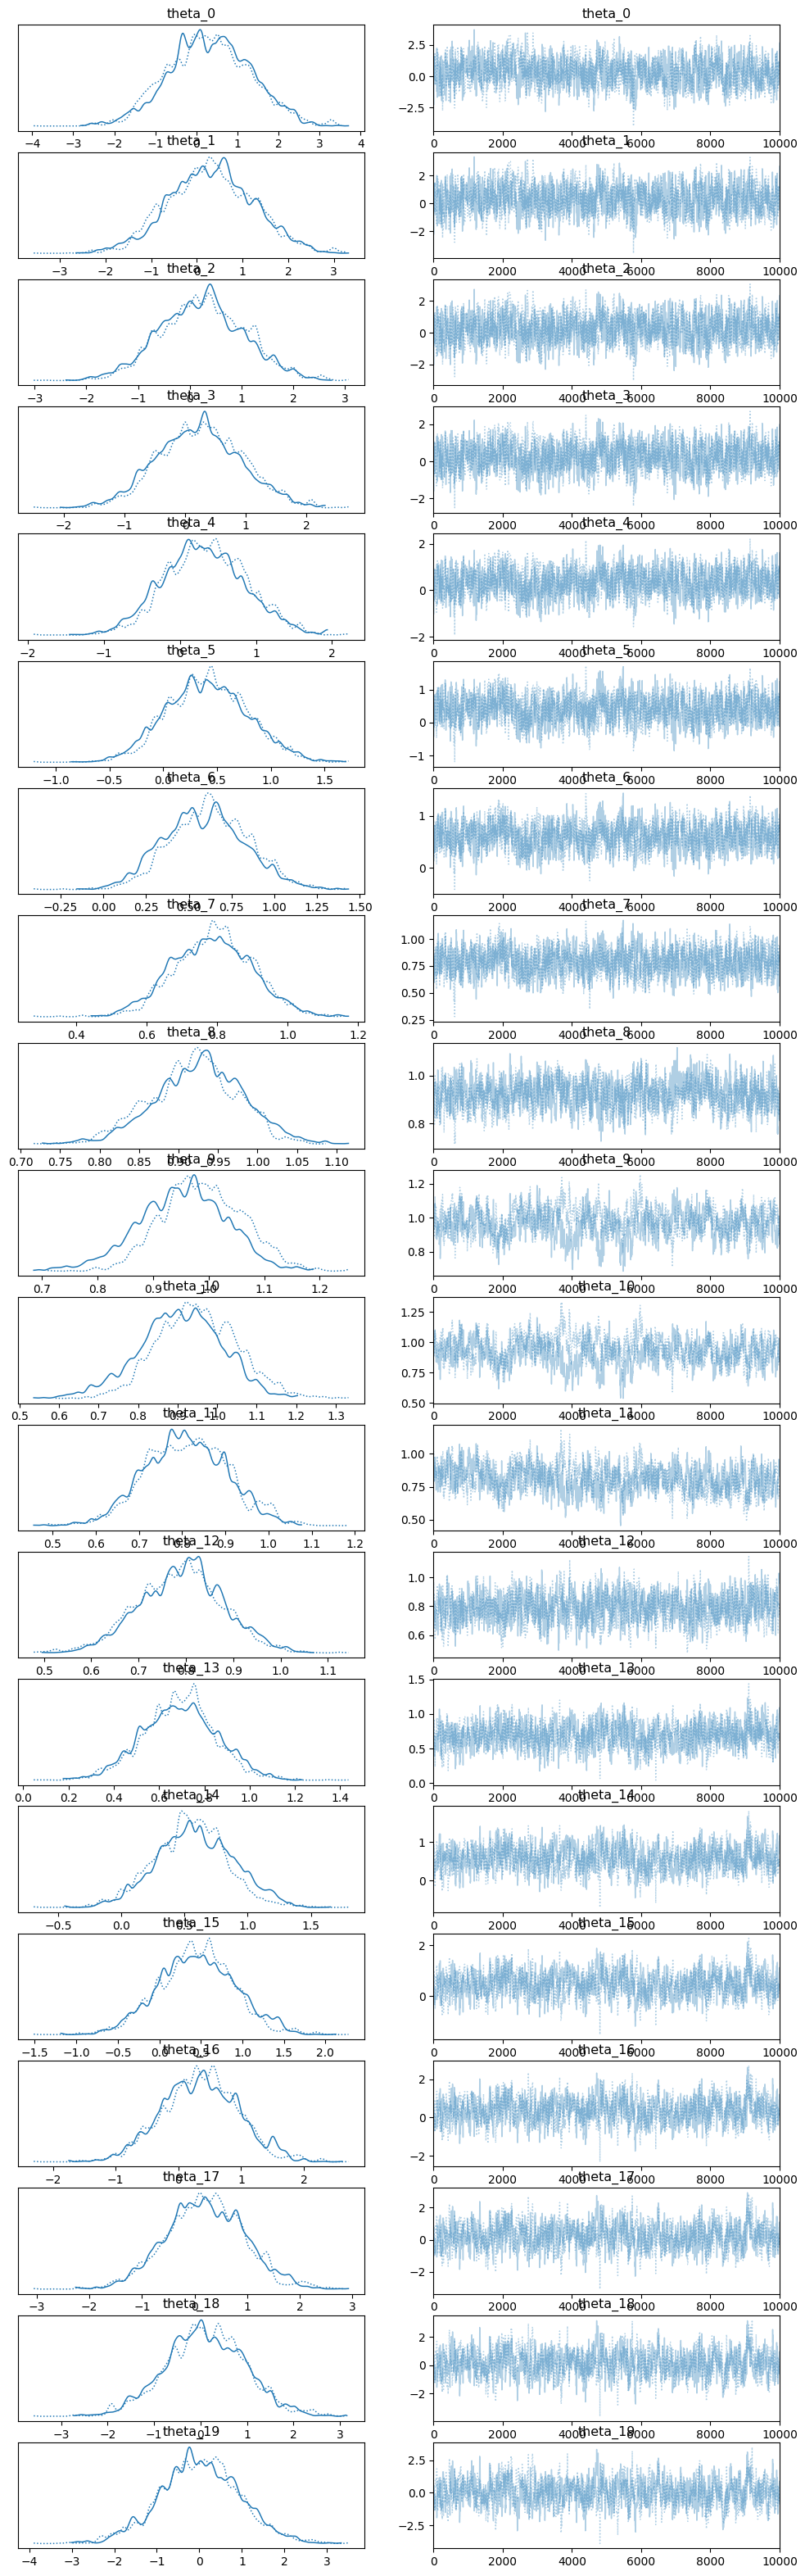

In [21]:
az.plot_trace(idata)
plt.show()

In [22]:
parameters = np.array([link.parameters for link in my_chains['chain_0'][burnin:] + my_chains['chain_1'][burnin:]])

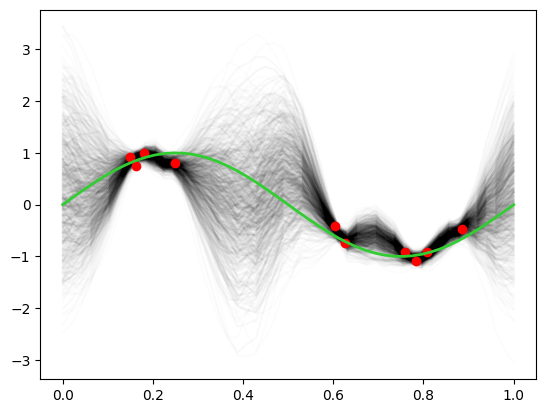

In [23]:
plt.plot(x, latent_function(x), c='limegreen', linewidth=2)
plt.scatter(x_data, y_data, c='r')
for i in range(1000):
    idx = np.random.randint(parameters.shape[0])
    plt.plot(x, parameters[idx,:], c='k', alpha=0.01, zorder=0)
plt.show()